# Red Wine Quality Predicting


## Introduction:
The wine industry has a considerable impact on the global economy, valued at USD 417.85 billion in 2020 it is growing steadily at an annual rate of 6.4%. Portugal is a top ten wine exporting country, with 3.17% of the market share in 2005 (Cortez et al., 2009). In our analysis, we will look into the physicochemical properties  - the physical and chemical attributes -  of red wine from Portugal in order to determine the best predictors of wine quality. Taste and quality can be very subjective, thus an objective measure of wine quality can help wine producers optimize their production process for quality.

We are planning to predict red wine quality using classification.


Our question is:

Given two predictors -- sulphates and volatile acidity, what will be the red wine quality?

The columns in the dataset are:

1. `Fixed Acidity` : a measure of g(tartaric acid)/dm3 which influences the stability, taste, odour and colour.
 
2. `Volatile Acidity` : a measure of g(acetic acid)/dm3 which is predominantly responsible for the sour vinegar-like taste notes.
 
3. `Citric Acid`: a measure of citric acid in (g / dm3) that contributes to the “fresh” flavour.
 
4. `Residual Sugar`: natural sugars left over from grapes measured in (g / dm3) creating a range of sweet to dry wines.
 
5. `Chlorides`: a measure of (sodium chloride - g / dm3) influencing the saltiness of wine.
 
6. `Free Sulfur Dioxide`: a measure of free sulfur dioxide (mg / dm3) that prevents oxidation and microbial spoilage.
 
7. `Total Sulfur Dioxide`: a measure of total sulfur dioxide (mg / dm3) that includes free and sulfur dioxides bound to other chemicals preventing spoilage.
 
8. `Density`: a measure of density (g / cm3) influencing the texture of wine.
 
9. `pH`: a measure of acidity/basicity of influencing the “softness” and “roundness”.
 
10. `Sulphates`: a measure of (potassium sulphate - g / dm3) that prevents renewed fermentation.
 
11. `Alcohol`: a measure of (% by volume) impacting the “body” and sweetness of wine.
 
12. `Quality (score between 0 and 10)`: based on sensory data evaluations by wine experts where 0 represents very bad and 10 very excellent.


The original datasets are available here:
- https://archive.ics.uci.edu/ml/datasets/Wine+Quality


In [81]:
 ### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ggplot2)
options(repr.matrix.max.rows = 6)

## Methods & Results

**Preliminary exploratory data analysis:**

In [82]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine <- read_csv2(url)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `fixed acidity` = col_number(),
  `volatile acidity` = col_character(),
  `citric acid` = col_character(),
  `residual sugar` = col_number(),
  chlorides = col_character(),
  `free sulfur dioxide` = col_number(),
  `total sulfur dioxide` = col_double(),
  density = col_character(),
  pH = col_number(),
  sulphates = col_character(),
  alcohol = col_number(),
  quality = col_double()
)

Warning message:
“2 parsing failures.
 row                  col               expected actual                                                                                         file
1296 total sulfur dioxide no trailing characters     .5 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
1297 total sulfur dioxide no trailing characters     .5 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
”

## Clean and wrangle our data

We cleaned and wrangled our data by converting "quality" column to be a factor and converting other columns to be double. 

Since we are focussing on classification here, our response variable (Quality in this case) should be categorical instead of a double. Therefore, we change it to be a factor by mutating the entire column.

Other columns are numerical variables so we need to convert every column to be a double, which is more precise.

In [83]:
colnames(wine) <- make.names(colnames(wine))

filtered <- wine 

wine <- wine %>% 
  mutate(quality = as_factor(quality),
        volatile.acidity = as.double(volatile.acidity),
    citric.acid = as.double(citric.acid),
  chlorides = as.double(chlorides),
  density = as.double(density),
  sulphates = as.double(sulphates))
  
wine

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.9970,326,0.65,98,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
63,0.510,0.13,23,0.076,29,40,0.99574,342,0.75,11,6
59,0.645,0.12,2,0.075,32,44,0.99547,357,0.71,102,5
6,0.310,0.47,36,0.067,18,42,0.99549,339,0.66,11,6


In [84]:
nrow(wine)

sum(is.na(wine))

wine_data <- na.omit(wine)
nrow(wine_data)

[1] 1599

[1] 2

[1] 1597

*We can conclude that there are totally 1599 rows and 2 rows have missing values.*

*We choose to remove these two missing value rows from the original data set.*

**Filtering all qualities of wine except 5, 6, 7**

In [85]:
num_obs <- nrow(wine_data)
wine_summary <- wine_data %>%
  group_by(quality) %>%
  summarize(
    count = n(),
    percentage = (count / num_obs) * 100)
wine_summary

`summarise()` ungrouping output (override with `.groups` argument)



quality,count,percentage
<fct>,<int>,<dbl>
3,10,0.6261741
4,53,3.3187226
5,679,42.5172198
6,638,39.9499061
7,199,12.4608641
8,18,1.1271133


From the table above, we realize that our dataset is unbalanced which means that our target variable (in this case quality), has more observations in specific classes than others. We noticed most of the observations were in 5, 6, 7 and the other quality classes had far less data points. In order to balance our data to produce a generate a higher accruacy classification model, we filter for these classes. 

In [86]:
filtered_wine <- wine_data %>% 
                 filter(quality %in% c(5, 6, 7))

filtered_wine

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.9970,326,0.65,98,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
63,0.510,0.13,23,0.076,29,40,0.99574,342,0.75,11,6
59,0.645,0.12,2,0.075,32,44,0.99547,357,0.71,102,5
6,0.310,0.47,36,0.067,18,42,0.99549,339,0.66,11,6


In [87]:
nrow(filtered_wine)
sum(is.na(filtered_wine))

[1] 1516

[1] 0

*We can conclude that there are totally 1516 rows and no missing value.*

## Split the wine data set into training data and testing data

We plan to split our data set into two parts, training and testing, to start our classification.

We choose 75% for our training data because we would like our training data to be the larger partition to find the model and we would like our testing data to be the smaller partition to test our model. 75% training and 25% testing split provides us a good balance between having a large data set to train our model and then having enough data to test it.

Our strata is our response variable, red wine quality here.

In [88]:
set.seed(15)

wine_split <- initial_split(filtered_wine, prop = 0.75, strata = quality)  
wine_train <- training(wine_split)
wine_test <- testing(wine_split)

wine_train
wine_test

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.76,0.04,23,0.092,15,54,0.9970,326,0.65,98,5
74,0.70,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
59,0.550,0.10,22,0.062,39,51,0.99512,352,0.76,112,6
63,0.510,0.13,23,0.076,29,40,0.99574,342,0.75,11,6
59,0.645,0.12,2,0.075,32,44,0.99547,357,0.71,102,5


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
78,0.88,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
112,0.28,0.56,19,0.075,17,60,0.9980,316,0.58,98,6
67,0.58,0.08,18,0.097,15,65,0.9959,328,0.54,92,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,0.39,0.44,26,0.066,22,48,0.99494,33,0.84,115,6
75,0.31,0.41,24,0.065,34,60,0.99492,334,0.85,114,6
6,0.31,0.47,36,0.067,18,42,0.99549,339,0.66,11,6


### Use ggpairs to decide predictors based on ggplots between physicochemical properties and red wine quality

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



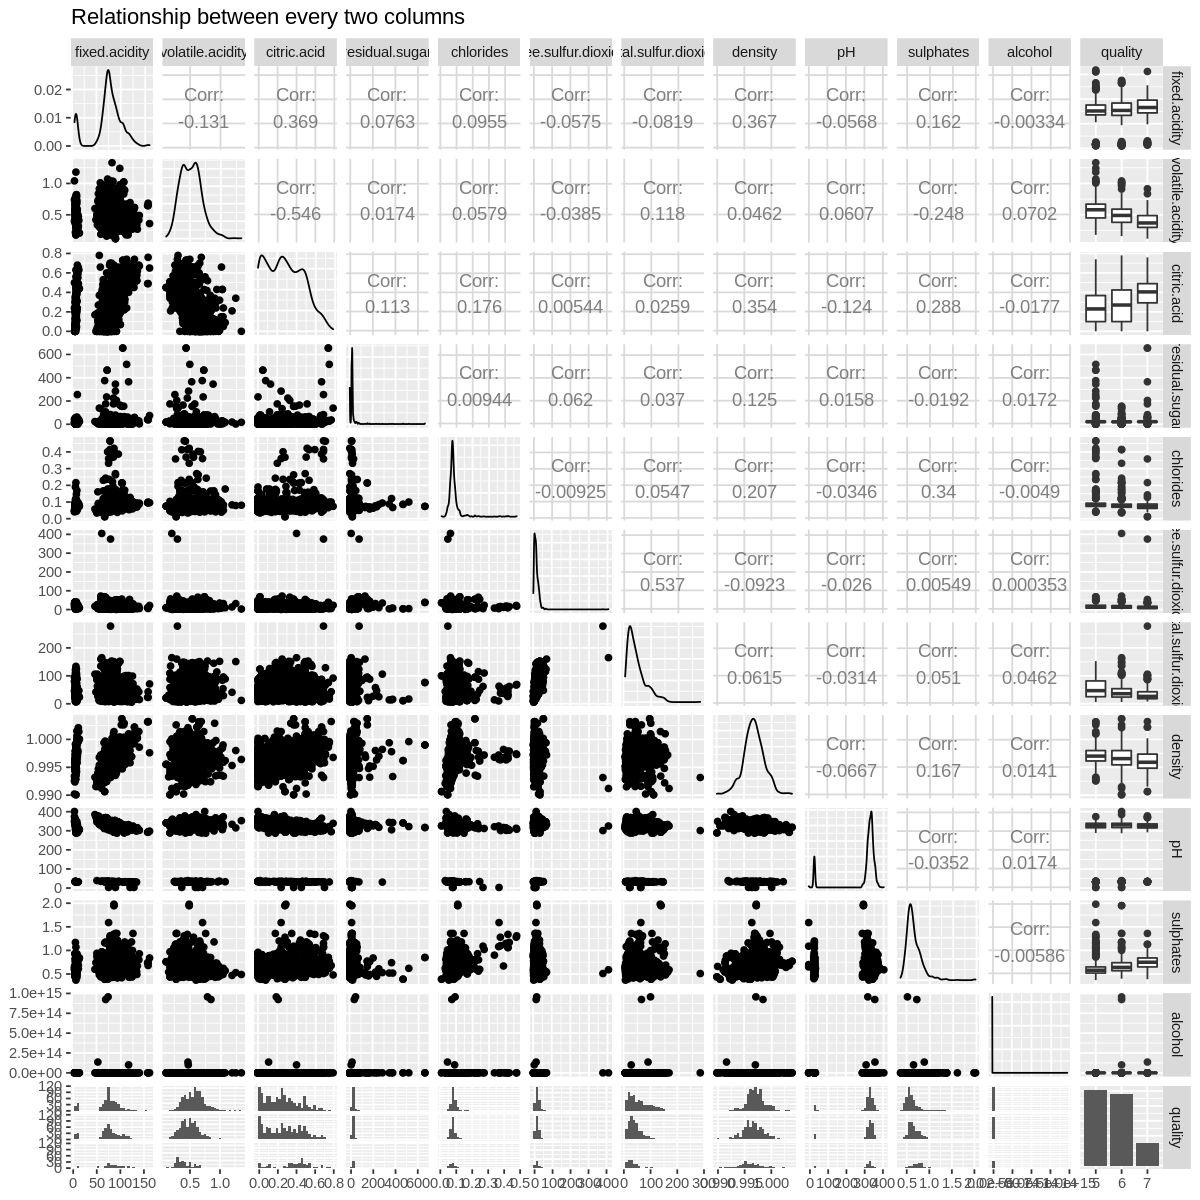

In [89]:
ggpairs(wine_train) + ggtitle("Relationship between every two columns")

From the graph above, we can conclude from the last column that contains the boxplots that sulphates and volatile acidity are appropriate predictors for red wine quality. Specifically, for volatile acidity there is a decreasing trend in the three box plots and they are not overlapping. For sulphates, there is a slightly increasing trend in the three boxplots that do not overlap. When boxplots do not overlap, it means we can have good confidence that the true means differ.

## Summary table for training data

In [90]:
num_obs_train <- nrow(wine_train)

wine_summary_train <- wine_train %>%
  group_by(quality) %>%
  summarize(
    count = n(),
    percentage = (count / num_obs_train) * 100,
    sulphates_mean = mean(sulphates, na.rm = TRUE),
    volatile.acidity_mean = mean(volatile.acidity, na.rm = TRUE)
  )

wine_summary_train

`summarise()` ungrouping output (override with `.groups` argument)



quality,count,percentage,sulphates_mean,volatile.acidity_mean
<fct>,<int>,<dbl>,<dbl>,<dbl>
5,510,44.77612,0.6175294,0.5769118
6,479,42.05443,0.6715449,0.4923173
7,150,13.16945,0.7488000,0.4044667


In [91]:
nrow(wine_train)

sum(is.na(wine_train))

[1] 1139

[1] 0

There are 1139 rows in the training data set and there are no rows with missing data.

## Training Data Visualization

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



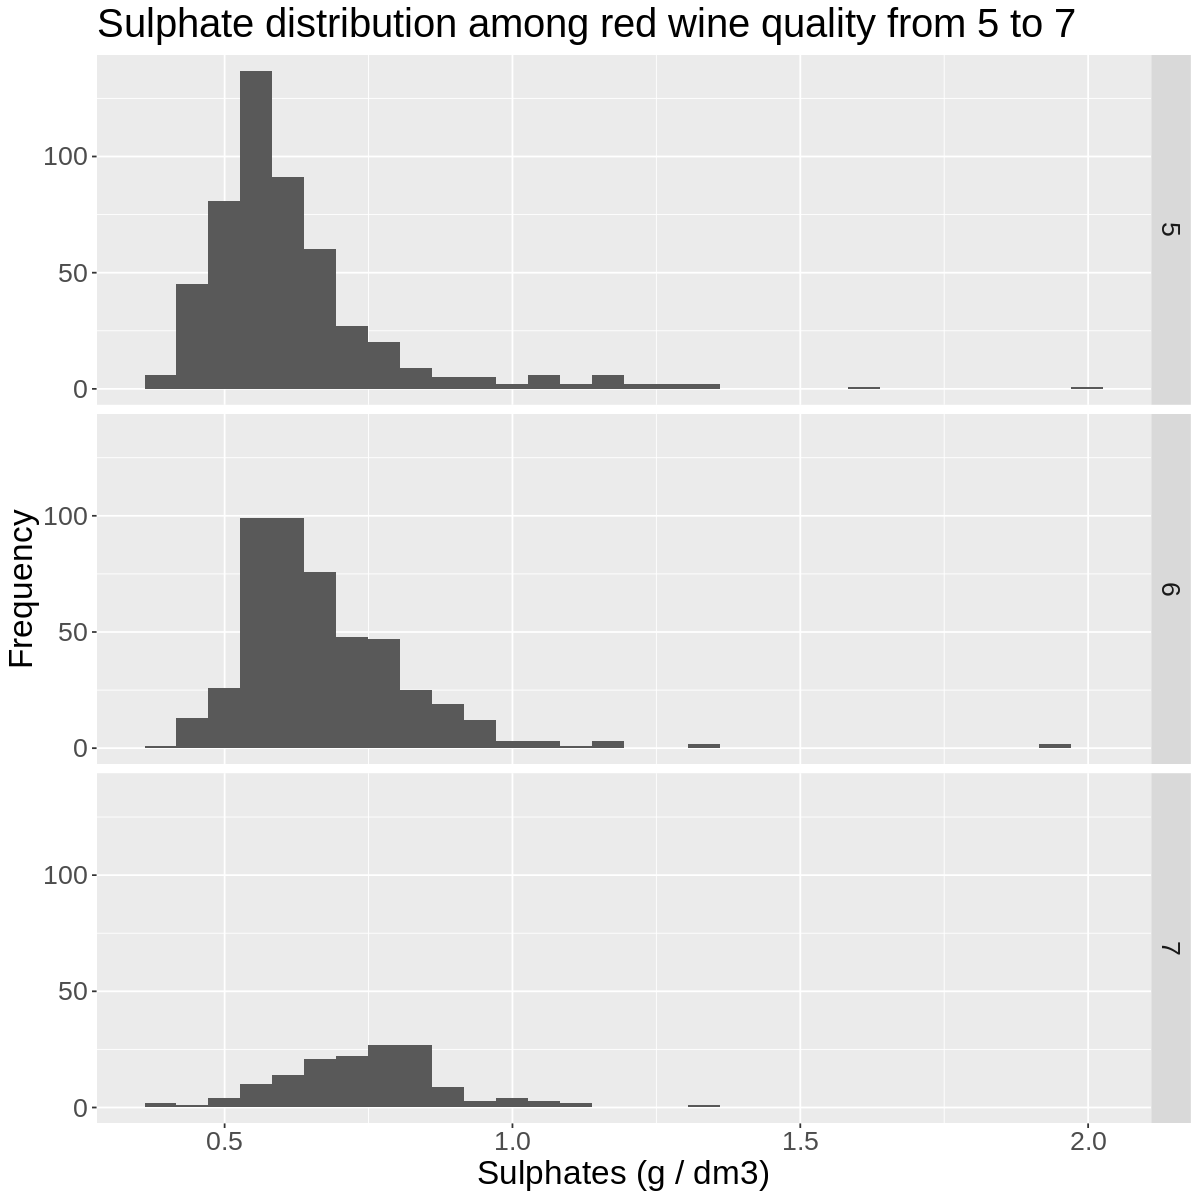

In [92]:
options(repr.plot.height = 10, repr.plot.width = 10)

wine_plot_sulphates <- wine_train %>% 
   ggplot(aes(x = sulphates)) + 
   geom_histogram(position = "identity") + 
   facet_grid(factor(quality) ~. ) +
   xlab("Sulphates (g / dm3)") + 
   ylab("Frequency") +
   theme(text = element_text(size=20)) +
   ggtitle("Sulphate distribution among red wine quality from 5 to 7")


wine_plot_sulphates

From the above graph, we can see that as the mean of sulphates increases, the quality of red wine is improved.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



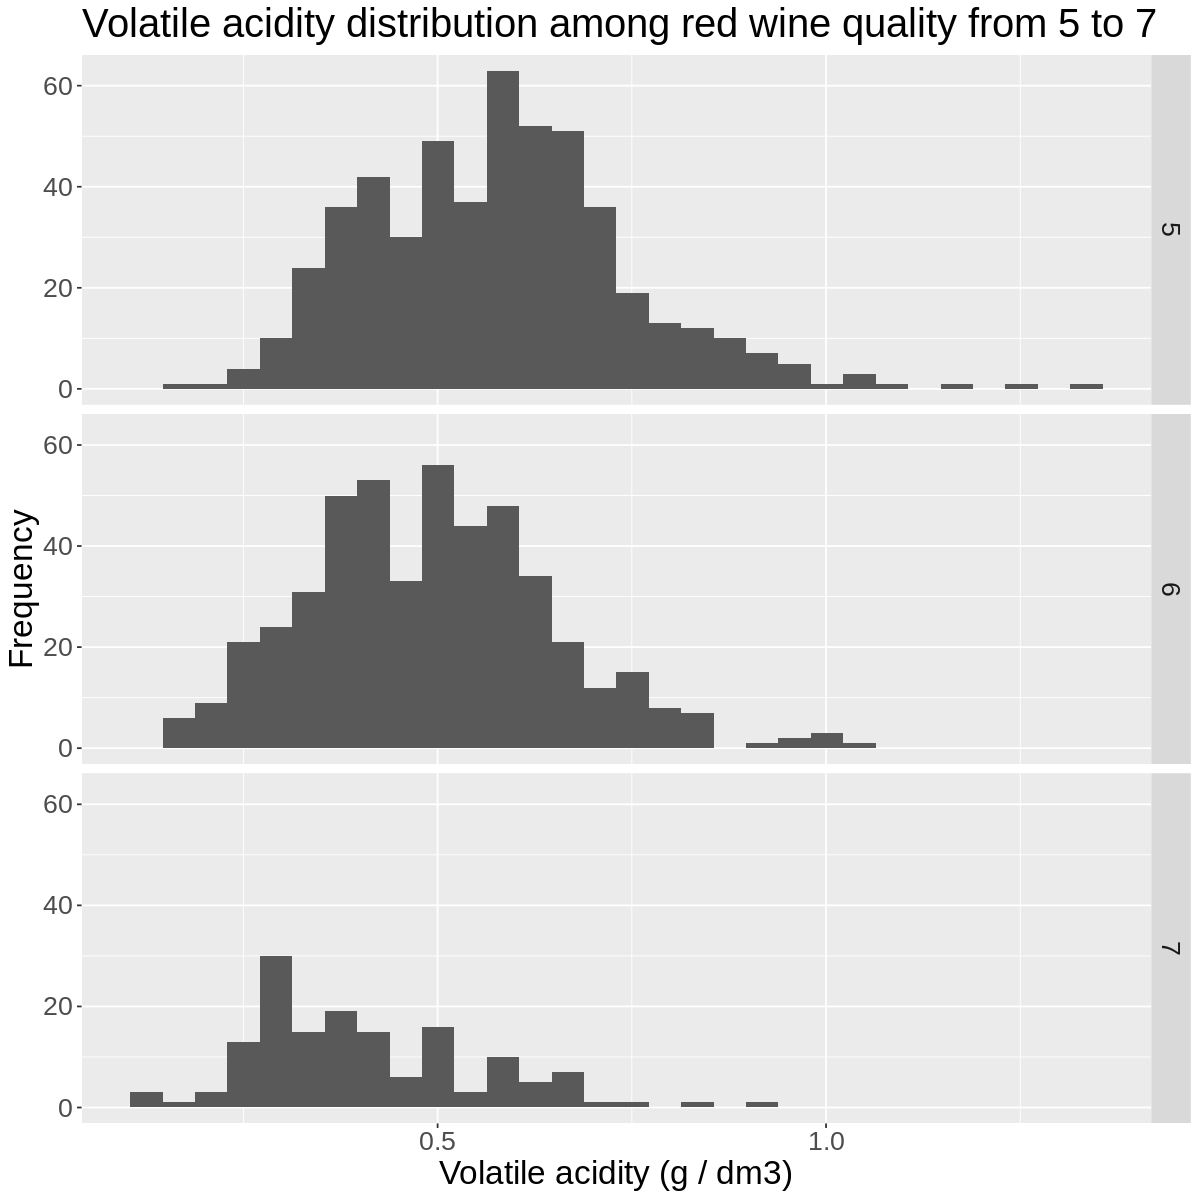

In [93]:
options(repr.plot.height = 10, repr.plot.width = 10)

wine_plot_volatile.acidity <- wine_train %>% 
   ggplot(aes(x = volatile.acidity)) + 
   geom_histogram(position = "identity") + 
   facet_grid(factor(quality) ~. ) +
   xlab("Volatile acidity (g / dm3)") + 
   ylab("Frequency") +
   theme(text = element_text(size=20)) +
   ggtitle("Volatile acidity distribution among red wine quality from 5 to 7")

wine_plot_volatile.acidity

From the above graph, we can see that as the mean of volatile acidity decreases, the quality of red wine is improved.

## Data analysis

In our analysis, we will create a knn classification model that predicts wine quality based on 2 predictors: sulphates and volatile acidity.

We have already split the data into training and testing data and will now train a classification model using the knn classification approach. The K -nearest neighbours classifier will find the  K  “nearest” or “most similar” observations in our training set, and then uses their label to make a prediction for the new observation’s red wine quality. 5-fold cross-validation will be used to determine an appropriate K-value. The v = # of folds, and strata = our categorical label variable, here quality. What cross-validation will do is split the training data in 5 evenly sized chunks. One of these chunks will be the validation set, and the other four chunks will be the training set. This process will estimate how accurately our model will work in practice will different K-values. We will then create a data analysis workflow, using the tune_grid fuction because we want to fit the model for each value in a range of paramter values that contain a sequence of K to try. A plot will then be produced to visualize accuracy estimate vs K-value, so that we can identify the most appropriate K parameter. We will then readjust our model to the best K, retrain, and test this model using our testing data. Finally, scatter plots will be provided for each pair of predictors. These plots will show our testing data points overlaid on the training data points and will be color-coded to show whether the model was accurate in classifying individual testing data points.



Summary of steps
1.	Use the initial_split function- training/test set strata = quality label variable. Put the test set aside for now.
2.	Use the vfold_cv function to split up the training data for cross-validation.
3.	Create a recipe that specifies the class label and predictors, as well as preprocessing steps for all variables which will include standardization in order to make the data for our predictors on comparable scales. Pass the training data as the data argument of the recipe.
4.	Create a nearest_neighbors model specification, with neighbors = tune().
5.	Add the recipe and model specification to a workflow(), and use the tune_grid function and *specify that the tuning should try 10 values of $K$* on the train/validation splits to estimate the classifier accuracy for a range of KK values.
6.	Plot the $k$ vs the accuracy to an object called 'cross_val_plot' and pick a value of KK that yields a high accuracy estimate that doesn’t change much if you change KK to a nearby value.
7.	Make a new model specification for the best parameter value (i.e., KK), and retrain the classifier using the fit function.
8.	Evaluate the estimated accuracy of the classifier on the test set using the predict function.


! Fold1: internal: No observations were detected in `truth` for level(s): '3', '4...

! Fold2: internal: No observations were detected in `truth` for level(s): '3', '4...

! Fold3: internal: No observations were detected in `truth` for level(s): '3', '4...

! Fold4: internal: No observations were detected in `truth` for level(s): '3', '4...

! Fold5: internal: No observations were detected in `truth` for level(s): '3', '4...



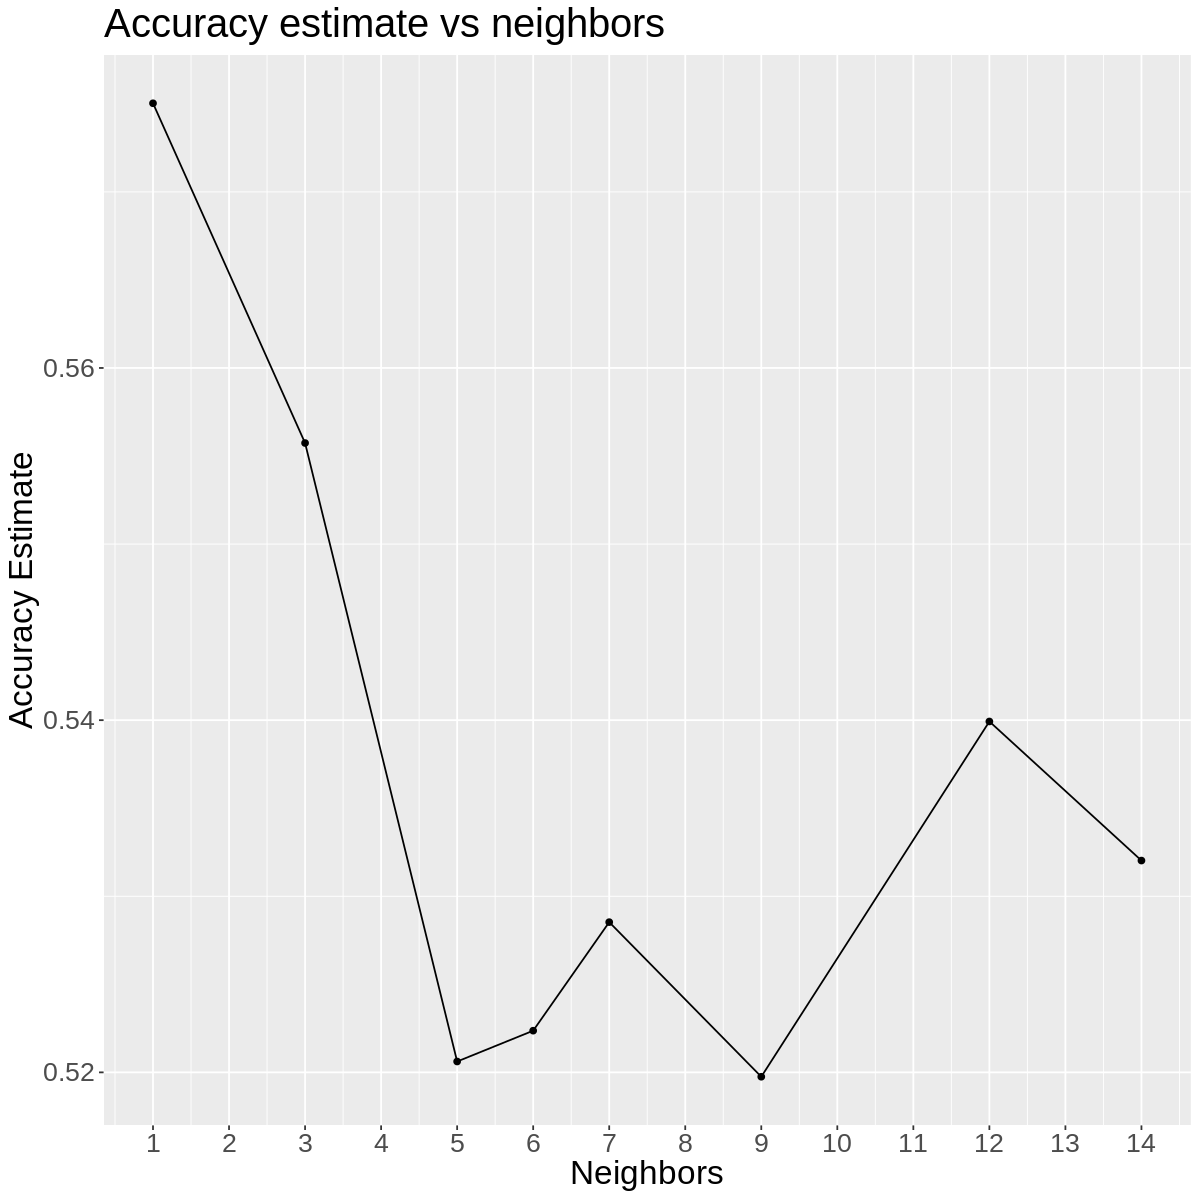

In [94]:
set.seed(1234)
wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

wine_recipe <- recipe(quality ~ volatile.acidity + sulphates, 
                        data = wine_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

wine_fit <- workflow() %>% 
    add_recipe(wine_recipe) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = wine_vfold, grid = 10) %>% 
    collect_metrics()

accuracies <- wine_fit %>% 
   filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
   geom_point() +
   geom_line() +
   labs(x = "Neighbors", y = "Accuracy Estimate") +
   ggtitle("Accuracy estimate vs neighbors") +
   scale_x_continuous(breaks = seq(0, 20, by = 1)) +
   theme(text = element_text(size = 20))
    

cross_val_plot

The highest accuracy estimate is around 0.58, so we can conclude that it's an accurate model. From the graph above, we will choose K = 1 because when neighbors are equal to 1, the estimated accuracy is the highest relative to the other K parameters.

## Building our model

Now that we have selected the K value of 1 which gives the highest estimated accruacy, we will set our final model neighbors argument to 1. Then we will retrain our classifier with the fit function.

In [95]:
set.seed(1234) 

wine_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 1) %>% 
   set_engine("kknn") %>% 
   set_mode("classification")

wine_fit <- workflow() %>% 
   add_recipe(wine_recipe) %>% 
   add_model(wine_spec) %>% 
   fit(data = wine_train)

wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~1, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3599649
Best kernel: rectangular
Best k: 1

## Testing our accuracy

We will use the metrics function to get the statistics about our model and specify the truth and estimate arguments. The
truth is the column name for the true value of the response variable (quality), and the estimate argument is the column 
name for the response variable predictors (.pred_class).

We will also create a confusion matrix for the classifier to show us a table of predicted labels and correct labels 
assigning to an object called wine_conf_mat.


In [96]:
set.seed(1234) 

wine_predictions <- predict(wine_fit,
                            wine_test) %>% 
                    bind_cols(wine_test)

wine_metrics <- metrics(wine_predictions,
                        truth = quality,
                        estimate = .pred_class)
wine_metrics

wine_conf_mat <- wine_predictions %>% 
     conf_mat(truth = quality,
             estimate = .pred_class)

wine_conf_mat$table <- wine_conf_mat$table[3:5, 3:5]

wine_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5649867
kap,multiclass,0.2780139


          Truth
Prediction  5  6  7
         5 99 43  8
         6 57 99 26
         7 13 17 15

## Visualization of the confusion matrix

We use autoplot to make a visualization of the confusion matrix to highlight our analysis.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



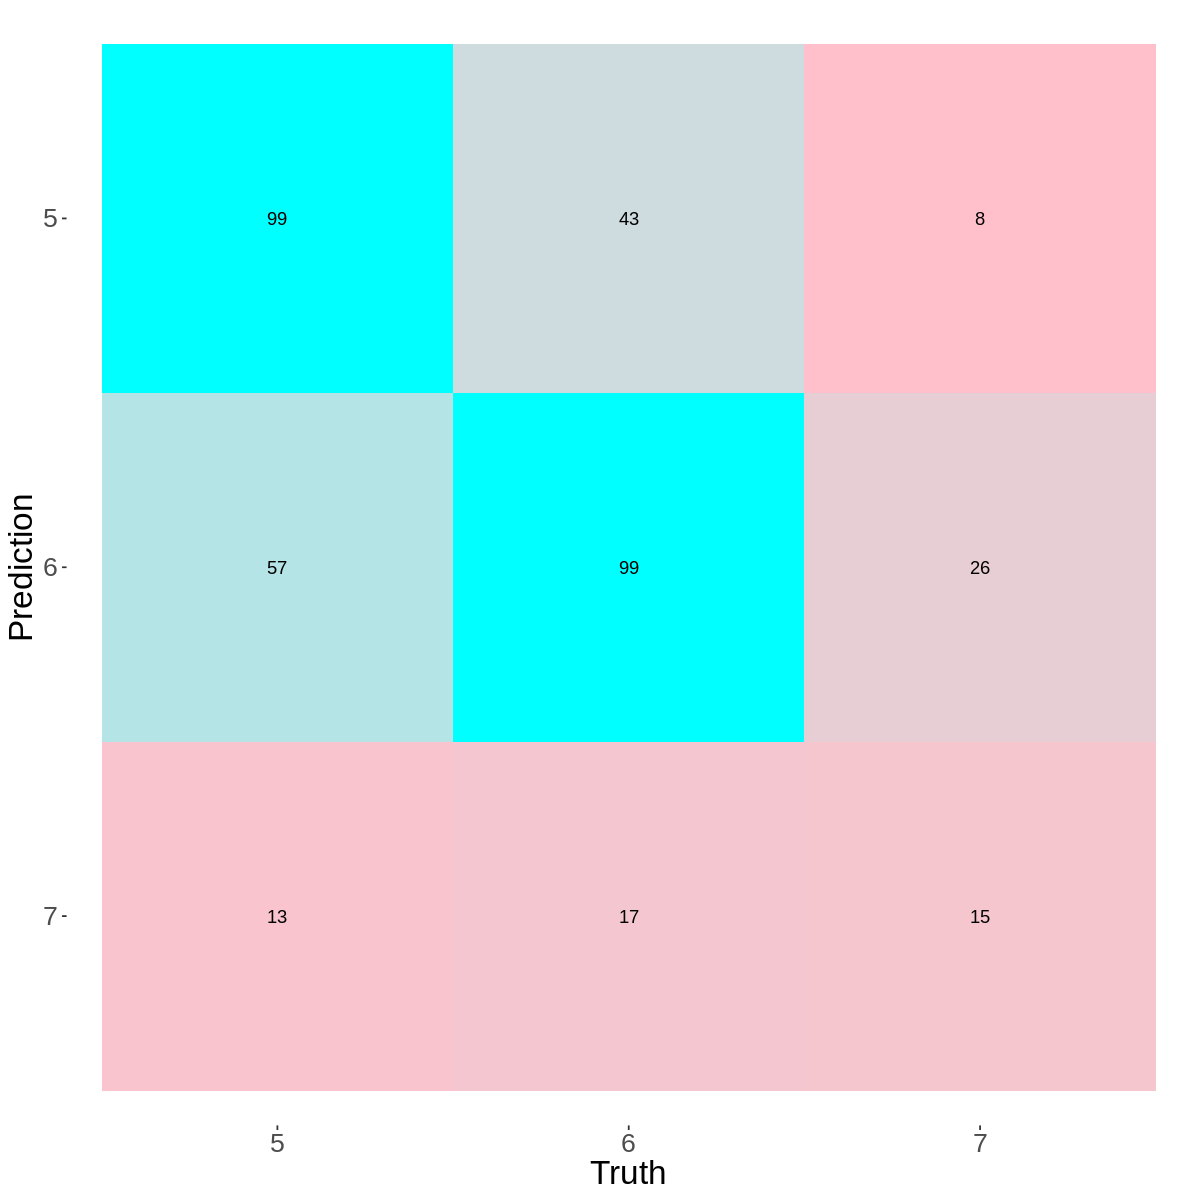

In [97]:
autoplot(wine_conf_mat, type = "heatmap") +
  scale_fill_gradient(low = "pink", high = "cyan") +
  theme(text = element_text(size = 20))

## Accuracy and confusion matrix results

Looking to the .estimate variable we can see that the estimated accuracy of our model is 56%. We can interpret this 
number as adequate as it is above 40%.

Regarding the confusion matrix, 99 observations were correctly predicted as quality 5, 99 observations were correctly predicted as quality 6, and 15 observations were correctly predicted as quality 7. Therefore the classifier correctly predicted 213 observations. 

It also shows that the classifier made some mistakes. For example, 57 observations were predicted as quality 6 when in fact they were 5, 43 observations were predicted as 5 when they were 6, 8 observations were predicted as 5 when they were 7, 26 observations were predicted as 6 when they were 7, 17 observations were predicted as 7 when they were 6, and 13 observations were predicted as 7 when they were 5. In total, 167 observations were predicted 
incorrectly.

Looking at accuracy estimates for each quality variable, you can see that the classifier does a much better job of predicting 5 and 6. This might indicate that the higher quality wines might not be so physicochemically different to wines slightly lower in quality, and that very small changes can lead to significant improvements in perceived wine quality.

## Discussion:

Our analysis shows that our predicitors, sulphates and volatile acidity, are reasonably good for predicting wines with a quality rating of 5 and 6, but our classifier performs poorer at predicting 7. There are two possible reasons why this might be the case. The first one might be that small physicochemical changes are enough to bump up the quality of the wine. Another is that perhaps higher quality wines get their high quality rating from perception or braning. People might rate a wine that isn't actually so different as higher quality if they knew what they were rating was high quality wine. As a result, high quality wine retailers might want to consider putting more money into branding than into changing the actual physicochemical properties of wine.

We expected to find useful insights that can impact the wine industry, specifically, understanding key physicochemical variables in red wine that can be controlled in the production process leading to higher quality wine. 

Our findings can influence the wine factories, and they will try to control important properties, such as sulphates and volatile acidity, to improve red wine quality. This can lead to further questions about how certain physicochemical factors can be controlled in the wine manufacturing process. 

Another question that we can ask is how other factors that will impact red wine quality. Idolo and Marshal (2019) found that the temperature at which the wine is stored will have a huge impact on red wine quality. Higher temperature leads to worse appearance, color, flavor and taste. These properties show that higher temperature corresponds to faster aging of wine. The outcome of this study suggests that low temperature storage might enhance wine quality.

This suggests that there are other possible factors that impact red wine quality. Consideration of these factors into a future study can lead to a more insightful and accurate model for red wine quality.

## Reference:

Cortez, Paulo, et al. "Modeling Wine Preferences by Data Mining from Physicochemical Properties." Decision Support Systems, vol. 47, no. 4, 2009, pp. 547-553.

Cortez, Paulo, et al. “Modeling Wine Preferences by Data Mining from Physicochemical Properties.” UCI Machine Learning Repository: Wine Quality Data Set, 2009, https://archive.ics.uci.edu/ml/datasets/Wine+Quality. 

Idolo, I., L. J. Marshall, and School of Food Science and Nutrition, University of Leeds, Leeds LS2 9JT. "The Effect of Ageing Temperature on the Sensory Qualities of Hibiscus Sabdariffa (Roselle) Wine." African Journal of Food, Agriculture, Nutrition, and Development : AJFAND, vol. 19, no. 3, 2019, pp. 14726-14738.